### Importing libraries & data.

In [1]:
import pandas as pd

from matplotlib import pyplot as plt
# from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches

from scipy.stats import gaussian_kde
from scipy.optimize import minimize_scalar

from numpy.polynomial.chebyshev import Chebyshev
import numpy as np

from rich.console import Console
from rich.table import Table

from multiprocessing import Pool, cpu_count

import fastkde

import constants, functions

### Defining functions (vectorized).

In [2]:
def mcmc_metropolis_hastings(n_steps, initial_params, initial_params_intervals, proposal_widths, calc_chi2_func):
    current_param1, current_param2 = initial_params
    interval_param1_1, interval_param1_2 = initial_params_intervals[0]
    interval_param2_1, interval_param2_2 = initial_params_intervals[1]
    chain = np.zeros((n_steps, 2))
    current_chi2 = calc_chi2_func(current_param1, current_param2)
    
    for i in range(n_steps):
        proposed_param1 = np.random.normal(current_param1, proposal_widths[0])
        proposed_param2 = np.random.normal(current_param2, proposal_widths[1])
        
        # Physical constraints
        if not (interval_param1_1 < proposed_param1 < interval_param1_2 and interval_param2_1 < proposed_param2 < interval_param2_2):
            chain[i] = [current_param1, current_param2]
            continue
        
        proposed_chi2 = calc_chi2_func(proposed_param1, proposed_param2)
        
        delta_chi2 = proposed_chi2 - current_chi2
        acceptance_prob = np.exp(-0.5 * delta_chi2)
        
        if np.random.rand() < acceptance_prob:
            current_param1, current_param2 = proposed_param1, proposed_param2
            current_chi2 = proposed_chi2
        
        chain[i] = [current_param1, current_param2]
    
    return chain

def run_single_chain(seed, initial_value1, initial_value2, initial_params_intervals, calc_chi2_func):
    np.random.seed(seed)
    return mcmc_metropolis_hastings(
        n_steps=n_steps // n_chains,
        initial_params=[initial_value1 + 0.01*np.random.randn(), initial_value2 + 0.01*np.random.randn()],
        initial_params_intervals=initial_params_intervals,
        proposal_widths=proposal_widths,
        calc_chi2_func=calc_chi2_func
    )

def run_chain(chain_func, var_names):
    n_chains = min(cpu_count(), 8)
    burn_in = 1000

    with Pool(n_chains) as pool:
        chains = pool.map(chain_func, range(n_chains))

    chain_all = np.vstack(chains)
    chain_clean = chain_all[burn_in:]

    x = chain_clean[:, 0]
    y = chain_clean[:, 1]

    PDF = fastkde.pdf(x, y, var_names=var_names, num_points=2**10 + 1)
    return PDF

### Plotting distribution

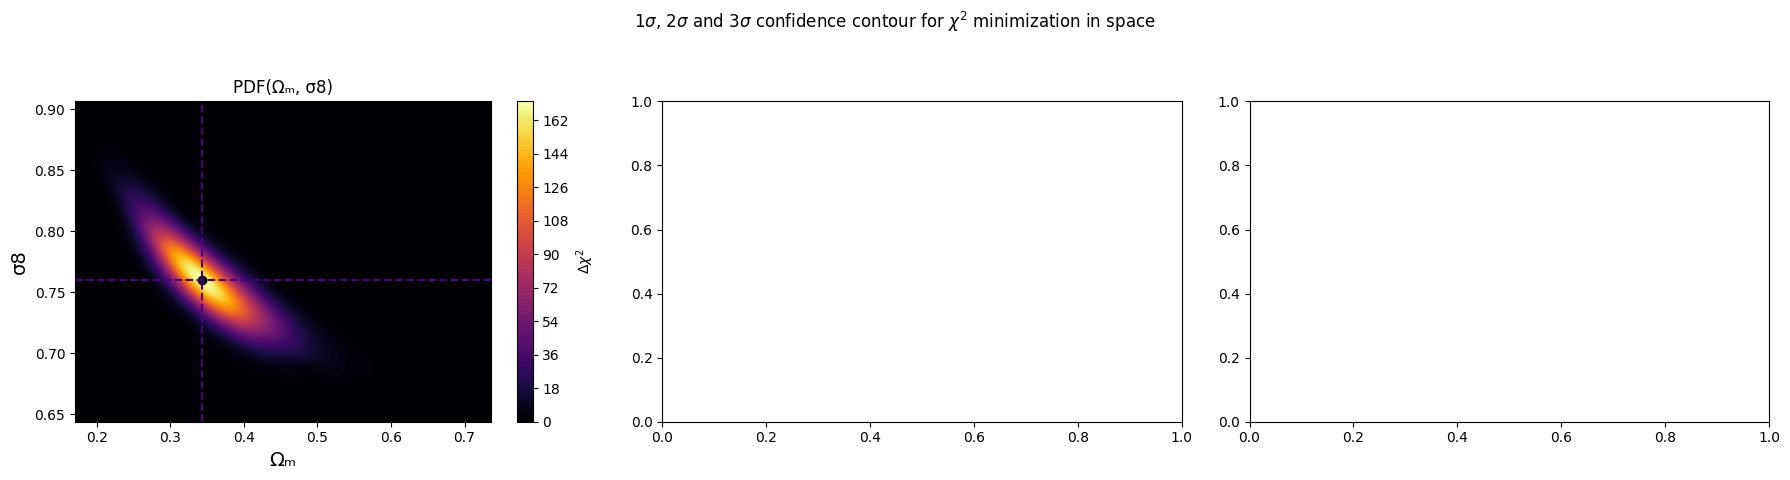

In [3]:
def run_single_chain_gamma_sigma(seed):
    return run_single_chain(seed, initial_value1=0.81, initial_value2=0.55, initial_params_intervals=[[0, 2], [0, 2]], calc_chi2_func=functions.calc_chi2_gamma_sigma)


def run_single_chain_gamma_omega(seed):
    return run_single_chain(seed, initial_value1=0.3, initial_value2=0.55, initial_params_intervals=[[0, 1], [0, 2]], calc_chi2_func=functions.calc_chi2_gamma_omega)


def run_single_chain_sigma_omega(seed):
    return run_single_chain(seed, initial_value1=0.3, initial_value2=0.81, initial_params_intervals=[[0, 1], [0, 2]], calc_chi2_func=functions.calc_chi2_sigma_omega_vectorized2)

n_steps = 100000
n_chains = min(cpu_count(), 8)
proposal_widths = [0.02, 0.01]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(r"1$\sigma$, 2$\sigma$ and 3$\sigma$ confidence contour for $\chi^2$ minimization in space")

PDF1 = run_chain(run_single_chain_sigma_omega, ['sigma', 'omega'])
functions.display_plot(PDF1, "Ωₘ", "σ8", axes[0])

# PDF2 = run_chain(run_single_chain_gamma_omega, ['omega', 'gamma'])
# functions.display_plot(PDF2, "γ", "Ωₘ", axes[1])

# PDF3 = run_chain(run_single_chain_gamma_sigma, ['gamma', 'sigma'])
# functions.display_plot(PDF3, "σ8", "γ", axes[2])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()